### Libraries

In [145]:
# Import the necessary libraries

# generic data science libraries
import pandas as pd
import numpy as np 

# plotting libraries    
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler

sns.set_style("darkgrid") # nice style

### Data
Kaggle data from https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset?resource=download

In [146]:
# Load the breast cancer dataset
data = pd.read_csv("Breast_cancer_data.csv")

# Check for missing values and drop rows with missing values
if data.isnull().any().any():
    print("Dataset contains missing values. Dropping rows with missing values.")
    data.dropna(inplace=True)
    
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


## Exploratory Data Analysis

<Axes: >

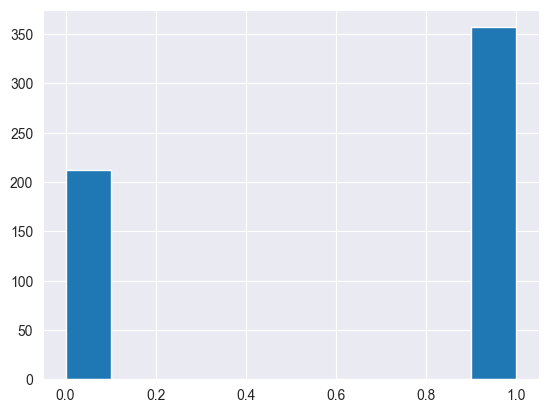

In [147]:
# checking distribution of the target variable
data["diagnosis"].hist()

We see that the dataset is unbalaced.

<Axes: >

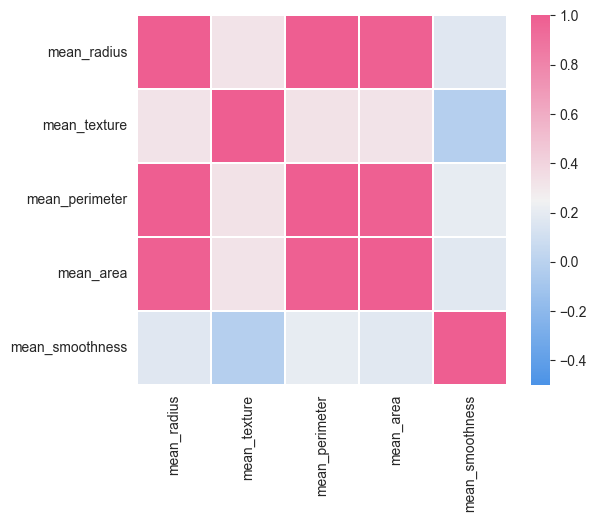

In [148]:
# Calculate and visualize the correlation matrix using a heatmap
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='light',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

Naive Bayes assumes independent features. Therefore we should avoid using highly correlated features such as radius and perimeter.

Clearly radius, perimeter and area are correlated so we should choose 1 of those 3 and the remaining 2 for a reasonably motivated result.

In [149]:
data = data[["mean_area", "mean_texture", "mean_smoothness", "diagnosis"]] # based of last row of correlation matrix
data.head(10)

,mean_area,mean_texture,mean_smoothness,diagnosis
0,1001.0,10.38,0.11840,0
1,1326.0,17.77,0.08474,0
2,1203.0,21.25,0.10960,0
3,386.1,20.38,0.14250,0
4,1297.0,14.34,0.10030,0
5,477.1,15.70,0.12780,0
6,1040.0,19.98,0.09463,0
7,577.9,20.83,0.11890,0
8,519.8,21.82,0.12730,0
9,475.9,24.04,0.11860,0


## Oversampling
In order to address the imbalance in the target (diagnosis), I have oversampled to even the distriubution.

In [150]:
data["diagnosis"].value_counts()

diagnosis
1    357
0    212
Name: count, dtype: int64

In [151]:
# Use RandomOverSampler to oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data.drop("diagnosis", axis=1), data["diagnosis"])

# Create a new DataFrame with the resampled data
data_resampled = pd.DataFrame(X_resampled, columns=data.columns[:-1])
data_resampled["diagnosis"] = y_resampled

data_resampled = data_resampled[["mean_area", "mean_texture", "mean_smoothness", "diagnosis"]]

In [152]:
data = data_resampled
data["diagnosis"].value_counts()

diagnosis
0    357
1    357
Name: count, dtype: int64

Now both are 357 each.

<Axes: >

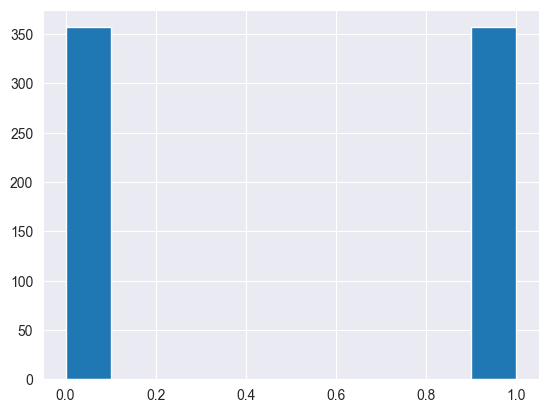

In [153]:
# balanced histogram
data["diagnosis"].hist()

Note that in this case oversampling reduced accuracy, which was 0.97 before oversampling.

## Continuous Method

<Axes: xlabel='mean_texture', ylabel='Count'>

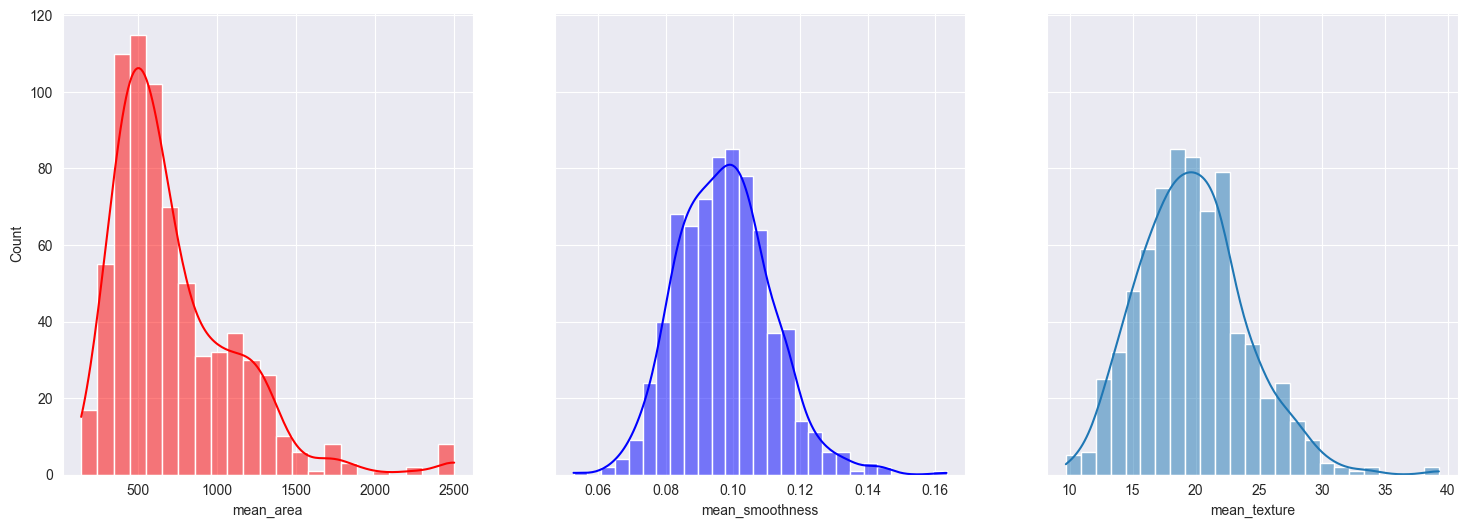

In [154]:
# Create subplots for histograms of selected features, will help in choosing the right continuous distribution approximation
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_area", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

Looks like a Gaussian distribution may suffice.

### Priori
Finding all Priori, $P(Y=y)$.

In [155]:
# Function to calculate the prior probabilities for each class
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df)) # instances of class divided by total instances
    return prior

### Continuous Liklihood Calculation
Liklihood, $P(X=x|Y=y)$, with Gaussian as it looks like a reasonable approximation from earlier.

In [156]:
# Function to calculate the likelihood for Gaussian Naive Bayes

def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label] # only takes the instances of the class we are interested in
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

To maximise the posterior, $P(Y|X)$, we can maximise the Liklihood*Prior as:  
$$
\begin{aligned}
P(Y|X) 
& = P(X^n|Y) * P(Y) 
& = P(X=x_1|Y=y)P(X=x_2|Y=y)...P(X=x_n|Y=y) * P(Y=y)
\end{aligned}
$$

In [157]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

### Evaluate Gaussian Approx model

In [158]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=.2, random_state=42)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")


print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))


[[62 12]
 [ 2 67]]
0.9054054054054054


## Discretised Method
Quantise the data into discrete bins

In [159]:
data

,mean_area,mean_texture,mean_smoothness,diagnosis
0,1001.0,10.38,0.11840,0
1,1326.0,17.77,0.08474,0
2,1203.0,21.25,0.10960,0
3,386.1,20.38,0.14250,0
4,1297.0,14.34,0.10030,0
...,...,...,...,...
709,642.7,20.22,0.09872,0
710,698.8,25.20,0.09387,0
711,1007.0,20.56,0.10010,0
712,588.9,22.29,0.12000,0


In [160]:
disc_df = data.copy()

disc_df["disc_mean_area"] = pd.cut(data["mean_area"].values, bins=4, labels=[0, 1, 2, 3])
disc_df["disc_mean_texture"] = pd.cut(data["mean_texture"].values, bins=4, labels=[0, 1, 2, 3])
disc_df["disc_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins=4, labels=[0, 1, 2, 3])

disc_df = disc_df.drop(columns=["mean_area", "mean_texture", "mean_smoothness"])
disc_df = disc_df[["disc_mean_area", "disc_mean_texture", "disc_mean_smoothness", "diagnosis"]]


### New Data Viualisation

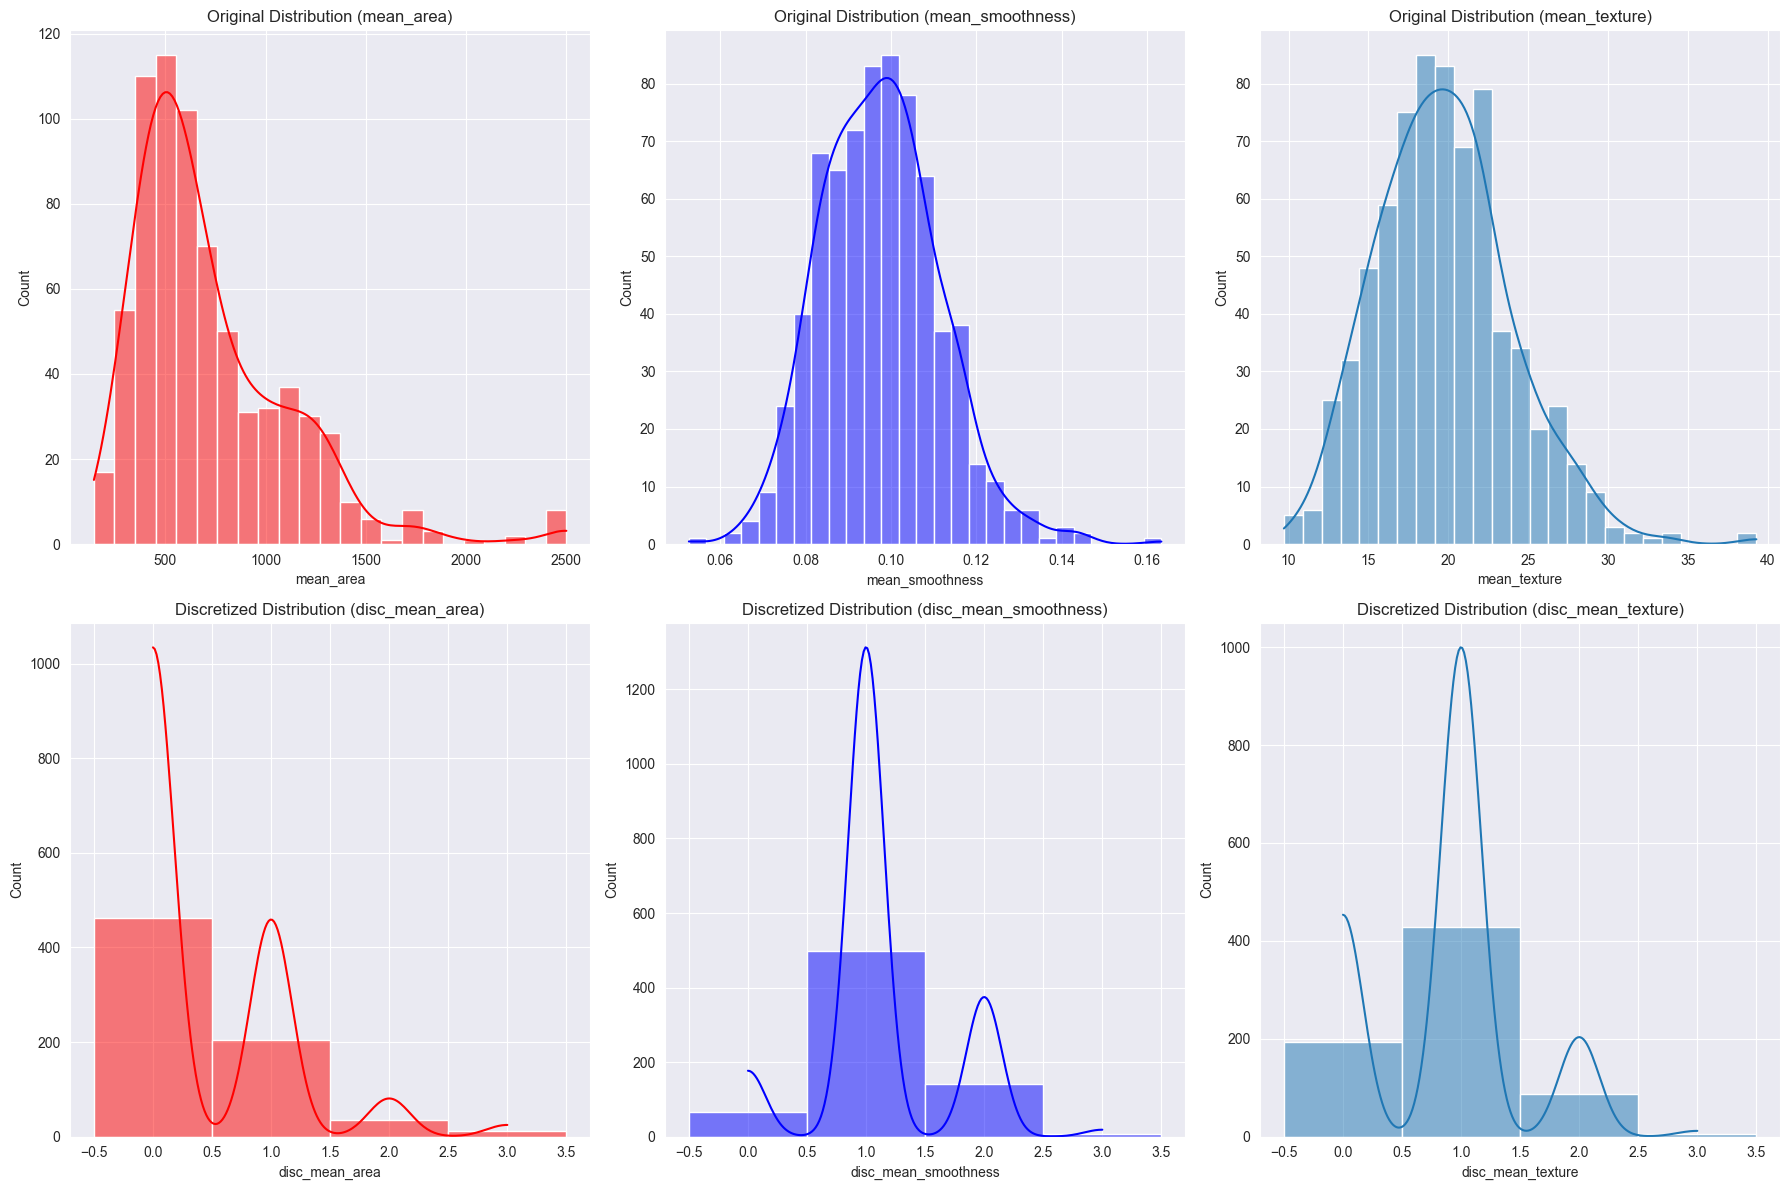

In [161]:
# Visualize the distribution of features before and after discretization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.histplot(data, ax=axes[0, 0], x="mean_area", kde=True, color='r')
axes[0, 0].set_title("Original Distribution (mean_area)")

sns.histplot(data, ax=axes[0, 1], x="mean_smoothness", kde=True, color='b')
axes[0, 1].set_title("Original Distribution (mean_smoothness)")

sns.histplot(data, ax=axes[0, 2], x="mean_texture", kde=True)
axes[0, 2].set_title("Original Distribution (mean_texture)")

# Visualize the distribution of discretized features
sns.histplot(disc_df, ax=axes[1, 0], x="disc_mean_area", kde=True, color='r')
axes[1, 0].set_title("Discretized Distribution (disc_mean_area)")

sns.histplot(disc_df, ax=axes[1, 1], x="disc_mean_smoothness", kde=True, color='b')
axes[1, 1].set_title("Discretized Distribution (disc_mean_smoothness)")

sns.histplot(disc_df, ax=axes[1, 2], x="disc_mean_texture", kde=True)
axes[1, 2].set_title("Discretized Distribution (disc_mean_texture)")

plt.tight_layout()
plt.show()

Have significantly lost resolution after discretising.

### Probability Calculations
Liklihood, $P(X=x|Y=y)$, using discrete bins instead of continuous values

In [162]:
def calculate_likelihood_disc(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

### Maximising Posteriori

$P(X=x_1|Y=y)P(X=x_2|Y=y)...P(X=x_n|Y=y) * P(Y=y)$



In [163]:
def naive_bayes_disc(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_disc(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

### Evaluate Discrete model

In [164]:
train, test = train_test_split(disc_df, test_size=0.2, random_state=42)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_disc(train, X=X_test, Y="diagnosis")

print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[61 13]
 [ 4 65]]
0.8843537414965987
